# Test PCNetwork
Purpose: To do initial testing of the `PCNetwork` class.

In [1031]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [887]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

# Dataset

In [1182]:
# Make my own dataset
A = torch.tensor([[ 1.3874, -0.2003,  0.4514],
                  [-0.0967, -0.4015,  1.3332]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 1.3874, -0.2003,  0.4514],
        [-0.0967, -0.4015,  1.3332]])
Target vectors
tensor([[1., 0.],
        [0., 1.]])


In [1059]:
# Make my own dataset
A = torch.tensor([[1, 0],[0,1]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[1., 0.],
        [0., 1.]])
Target vectors
tensor([[1., 0.],
        [0., 1.]])


In [1100]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(B)
    bottom_dim = n_classes

    training_input = []
    training_output = []
    for idx in range(n):
        r = np.random.randint(n_classes)
        training_output.append(B[r])
        training_input.append(A[r]+noise*torch.randn_like(A[r]))

    training_input = torch.stack(training_input)
    training_output = torch.stack(training_output)
    train = [training_input, training_output]
    return train

train = MakeDataset(A, B, n=10, noise=0.)

In [1183]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        n_classes = len(A)
        for i in range(n):
            r = np.random.randint(n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)

In [1080]:
blah = SimpleDataset(A, B, n=10, noise=0.0)

# Create Network

In [1268]:
net = PCNetwork.PCNetwork()

net.AddLayer(PCLayer.PCLayer(n=np.shape(A)[1]))  # v0 (input layer)
net.AddLayer(PCLayer.PCLayer(n=2))  # / e1
net.AddLayer(PCLayer.PCLayer(n=2))  # \ v1 (output layer)

net.lyr[1].SetDecay(1.)  # decay rate for error nodes
net.Connect(v_idx=0, e_idx=1, type='general', sym=True, act_text='identity')
net.Connect(e_idx=1, v_idx=2, type='1to1')

net.SetTau(0.05)
net.Learning(True)
net.SetWeightDecay(0.04)

In [1269]:
net.SetActivityDecay(0.01)

In [1270]:
#net.con[0].SetIdentity()
#net.con[1].SetIdentity()

In [1271]:
#net.Save('my.net')
#net2 = PCNetwork.PCNetwork.Load('my.net')

# Test

In [1272]:
net.lyr[0].Probe(True)
net.lyr[1].Probe(True)
net.lyr[2].Probe(True)

In [1273]:
net.Predict(A, T=4.)

tensor([[-3.3349, -0.5307],
        [ 1.1367, -1.2125]])

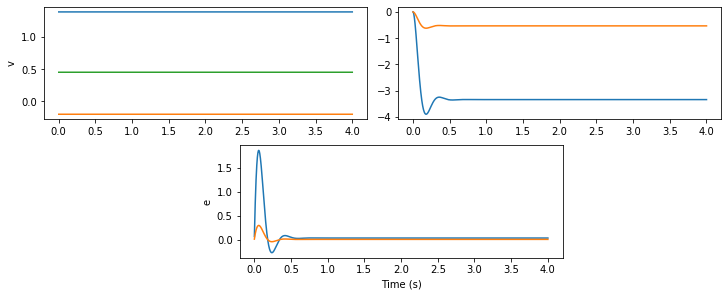

In [1274]:
net.Plot(idx=[0]);

In [1275]:
simple_ds = SimpleDataset(A, B, n=4, noise=0.0)

In [1276]:
net.Reset()
net.Learn(DataLoader(simple_ds, batch_size=2, shuffle=True), T=1., epochs=5)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [1277]:
net.Reset()
net.Predict(A, T=4.)

tensor([[0.9709, 0.0053],
        [0.0053, 0.9687]])

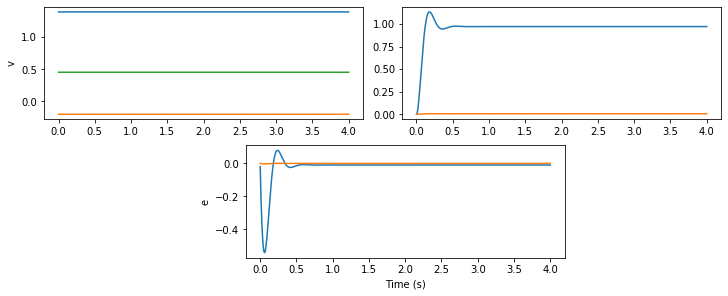

In [1278]:
fig = net.Plot(idx=0)

In [1279]:
net.Reset()
net.Generate(B, T=4.)

tensor([[ 1.3842, -0.2101,  0.4311],
        [-0.1130, -0.4220,  1.3237]])

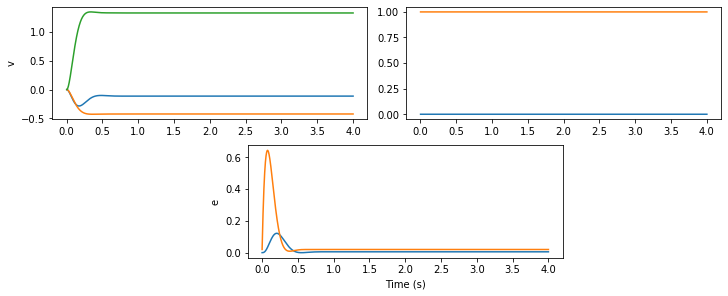

In [1280]:
net.Plot(idx=1);

tensor([[ 1.3842, -0.2101,  0.4311],
        [-0.1130, -0.4220,  1.3237]])
tensor([[ 1.3874, -0.2003,  0.4514],
        [-0.0967, -0.4015,  1.3332]])


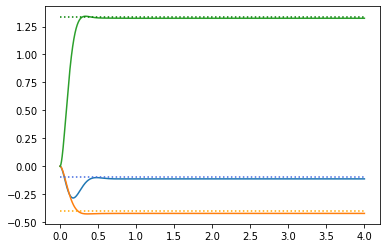

In [1283]:
print(net.lyr[0].x)
print(A)
idx = 1
colours = ['royalblue', 'orange', 'green'];
net.lyr[0].Plot(net.t_history, idx=idx)
for k,a in enumerate(A[idx]):
    plt.plot([net.t_history[0],net.t_history[-1]], [a,a], ':', color=colours[k]);